In [1]:
library("tidyverse")
library("cowplot")
library("FactoMineR")
library("factoextra")
library("RColorBrewer")
library("umap")
library("patchwork")
set.seed(42)
# import filtered count tables and metatables
getwd()
fnames <- list.files(pattern = "*_vsdTPM.csv")
vsdlist = list()
collist = list()
# first create an overlap of common hogs across all accessions
for (i in fnames) {
    vsd_df <- read.table(i, row.names = 1, header = TRUE, sep = ",", stringsAsFactors = FALSE)
    vsd_t <- as.data.frame(t(vsd_df), stringsAsFactors = TRUE) %>% rownames_to_column("ID")
    cols <- colnames(vsd_t)
    collist[[i]] <- cols
}
str(collist)
common_hogs <- Reduce(intersect, collist)
str(common_hogs)
# there are 11,816 commonly highly expressed hogs
for (i in fnames) {
    vsd_df <- read.table(i, row.names = 1, header = TRUE, sep = ",", stringsAsFactors = FALSE)
    vsd_t <- as.data.frame(t(vsd_df), stringsAsFactors = TRUE) %>% 
                rownames_to_column("ID") %>%
                select(matches(common_hogs))
    vsdlist[[i]] <- vsd_t
}
all_vsd <- do.call(rbind, vsdlist)
dim(all_vsd)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ───────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




List of 20
 $ Akashinriki_vsdTPM.csv  : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ B1K_vsdTPM.csv          : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ Barke_vsdTPM.csv        : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ GoldenPromise_vsdTPM.csv: chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ Hockett_vsdTPM.csv      : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR10350_vsdTPM.csv     : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR13821_vsdTPM.csv     : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR13942_vsdTPM.csv     : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR21599_vsdTPM.csv     : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR3081_vsdTPM.csv      : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1H00015" ...
 $ HOR3365_vsdTPM.csv      : chr [1:13653] "ID" "chr1H00008" "chr1H00009" "chr1

[1]   296 13653

In [2]:
getwd()
meta <- read.table("PanBaRT20_geneTPM_meta.csv", sep = ",", header = TRUE, stringsAsFactors = TRUE)
dim(meta)
head(meta, 3)
# import and wrangle barley accessions passport data
getwd()
passport <- read.table("BPGv1v2_passport_data_simpleaccname.csv", sep = ",", header = TRUE, stringsAsFactors = TRUE)
head(passport, 3)
pass <- passport %>% rename(Accession = accession)
meta_pass <- inner_join(meta, pass, by = "Accession") %>% 
                select(-idx, -group, -name, -gbs.sample.id, -latitude, -longitude, -adm_col_Milner2019, -adm_q, -orange_subpop, -remark, -X)
str(meta_pass)
# prepare counts and metatable for pca
cnt_pca <- inner_join(all_vsd, meta_pass, by = "ID") %>%
                mutate(id = ID) %>% 
                column_to_rownames("ID") %>% 
                rename(ID = id) %>% 
                select(ID, Accession, Tissue, Batch, ssp, status.1, status.2, country_of_origin, row_type, annual_growth_habit, awn_roughness, glume_color, grain_hull, starts_with("chr"))

[1] 297   4

,ID,Accession,Tissue,Batch
,<fct>,<fct>,<fct>,<int>
1,Akashinriki_Ca1,Akashinriki,Caryopsis,1
2,Akashinriki_Ca2,Akashinriki,Caryopsis,2
3,Akashinriki_Ca3,Akashinriki,Caryopsis,3


,idx,group,ssp,accession,name,gbs.sample.id,status.1,status.2,country_of_origin,latitude,⋯,adm_col_Milner2019,adm_q,orange_subpop,row_type,annual_growth_habit,awn_roughness,glume_color,grain_hull,remark,X
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,⋯,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,pangenome_V1,vulgare,GoldenPromise,BCC1382,BRIDGE_BCC_1382,cultivated,cultivar,GBR,NA,⋯,red,0.736967,,2-rowed,spring,,,hulled,,
2,2,pangenome_V1,vulgare,OUN333,Chame 1,BRIDGE_BCC_747,cultivated,landrace,NPL,NA,⋯,black,0.999890,,intermedium,intermediate,,,hulled,BCC_747,
3,3,pangenome_V1,vulgare,Morex,BCC906,BRIDGE_BCC_906,cultivated,cultivar,USA,NA,⋯,darkred,0.878059,,6-rowed,spring,smooth,,hulled,,


'data.frame':	297 obs. of  13 variables:
 $ ID                 : Factor w/ 297 levels "Akashinriki_Ca1",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Accession          : Factor w/ 76 levels "Akashinriki",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Tissue             : Factor w/ 5 levels "Caryopsis","Coleoptiles",..: 1 1 1 2 2 2 3 3 3 4 ...
 $ Batch              : int  1 2 3 1 2 3 1 2 3 1 ...
 $ ssp                : Factor w/ 3 levels "agriocrithon",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ status.1           : Factor w/ 3 levels "cultivated","feral",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ status.2           : Factor w/ 4 levels "cultivar","feral",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ country_of_origin  : Factor w/ 32 levels "","AFG","AUS",..: 18 18 18 18 18 18 18 18 18 18 ...
 $ row_type           : Factor w/ 6 levels "","2-rowed","6-rowed",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ annual_growth_habit: Factor w/ 5 levels "","facultative",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ awn_roughness      : Factor w/ 3 levels "","rough","smooth": 2 2 2 2 2 2 2 2 2 2 

In [3]:
# convert to factors
cols <- c("ID", "Accession", "Tissue", "Batch", "ssp", "status.1", "status.2", "country_of_origin", "row_type", "annual_growth_habit", "awn_roughness", "glume_color", "grain_hull")
cnt_pca[cols] <- lapply(cnt_pca[cols], factor)
# drop extra factor levels
cnt_pca <- droplevels(cnt_pca)
# run pca
dim(cnt_pca)
pca <- PCA(X = cnt_pca, scale.unit = FALSE, ncp = 4, quali.sup = c(1:13), graph = F)

[1]   296 13665

In [1]:
# visualize PCAs
scree <- fviz_eig(pca, addlabels = TRUE) +
            theme_bw()
pca1 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Tissue", title = "PanBarley variance stabilized 1:1 orthologs", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$Tissue, pointsize = 6) +
                scale_color_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                   limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                      values = c(15,19,17,18,20)) +
                scale_fill_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                  limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                  labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca2 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Tissue", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$Tissue, pointsize = 6) +
                scale_color_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                   limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                   labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                      values = c(15,19,17,18,20)) +
                scale_fill_manual(values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"),
                                  limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                  labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca3 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Accession", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$Accession, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,23,25)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca4 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Accession", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$Accession, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,23,25)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=20),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca5 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Status.2", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$status.2, pointsize = 6) +
                scale_shape_manual(values = c(15,19,17,18)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca6 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Status.2", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$status.2, pointsize = 6) +
                scale_shape_manual(values = c(15,19,17,18)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca7 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Country", title = "PanBarley variance stabilized 1:1 orthologs", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$country_of_origin, pointsize = 6) +
                #scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca8 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Country", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$country_of_origin, pointsize = 6) +
                #scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=20),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca9 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Row-type", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$row_type, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4,5)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca10 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Row-type", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$row_type, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4,5)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca11 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Growth habit", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$annual_growth_habit, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca12 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Growth habit", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$annual_growth_habit, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3,4)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca13 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Awn roughness", title = "PanBarley variance stabilized 1:1 orthologs", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$awn_roughness, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca14 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Awn roughness", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$awn_roughness, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca15 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Glume color", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$glume_color, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca16 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Glume color", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$glume_color, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2,3)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")
pca17 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Grain hull", title = "", addEllipses = FALSE, axes = c(1, 2), habillage = cnt_pca$grain_hull, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.position = "none",
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC1") + 
                ylab("PC2")
pca18 <- fviz_pca_ind(X = pca, label = "none", legend.title = "Grain hull", title = "", addEllipses = FALSE, axes = c(3, 4), habillage = cnt_pca$grain_hull, pointsize = 6) +
                scale_shape_manual(values = c(0,1,2)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6))) +
                xlab("PC3") + 
                ylab("PC4")

ERROR: Error in fviz_eig(pca, addlabels = TRUE): could not find function "fviz_eig"


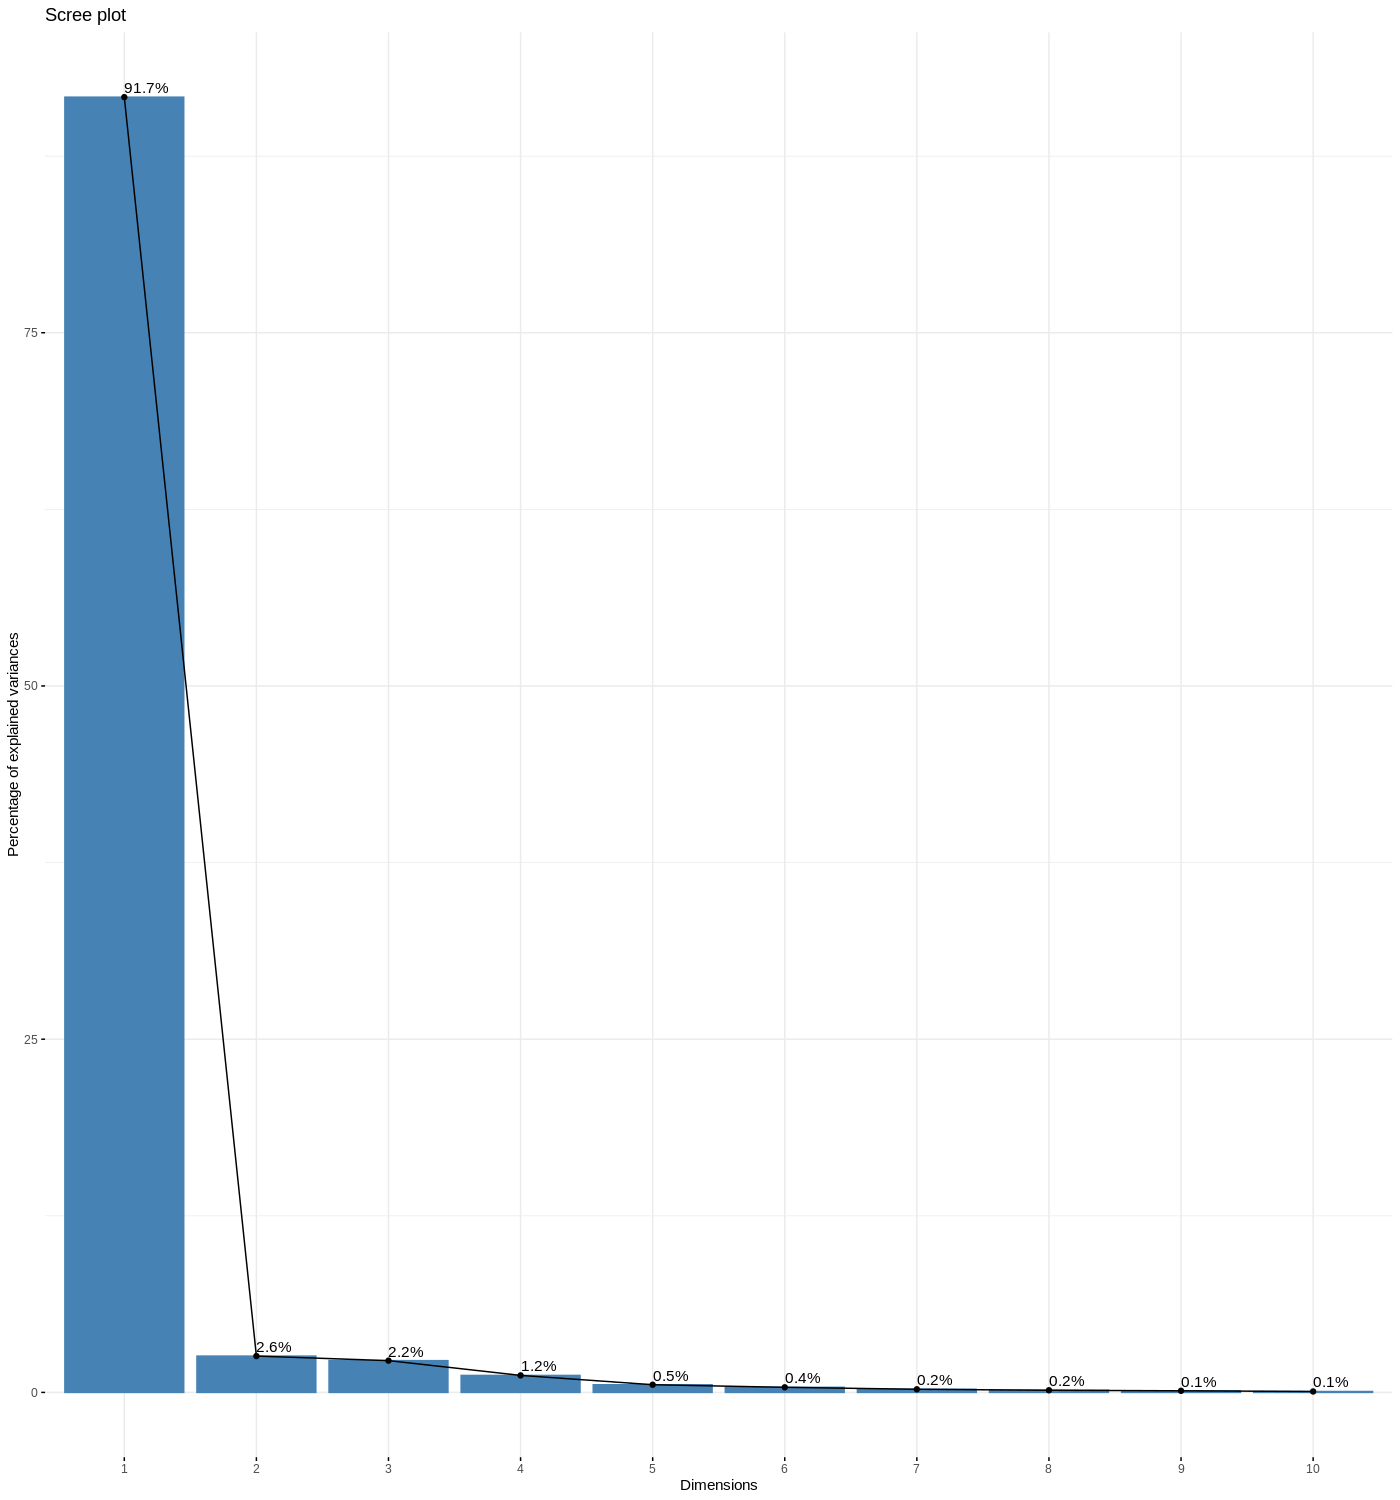

In [5]:
options(repr.plot.width = 14, repr.plot.height = 15, repr.plot.res = 100)
scree

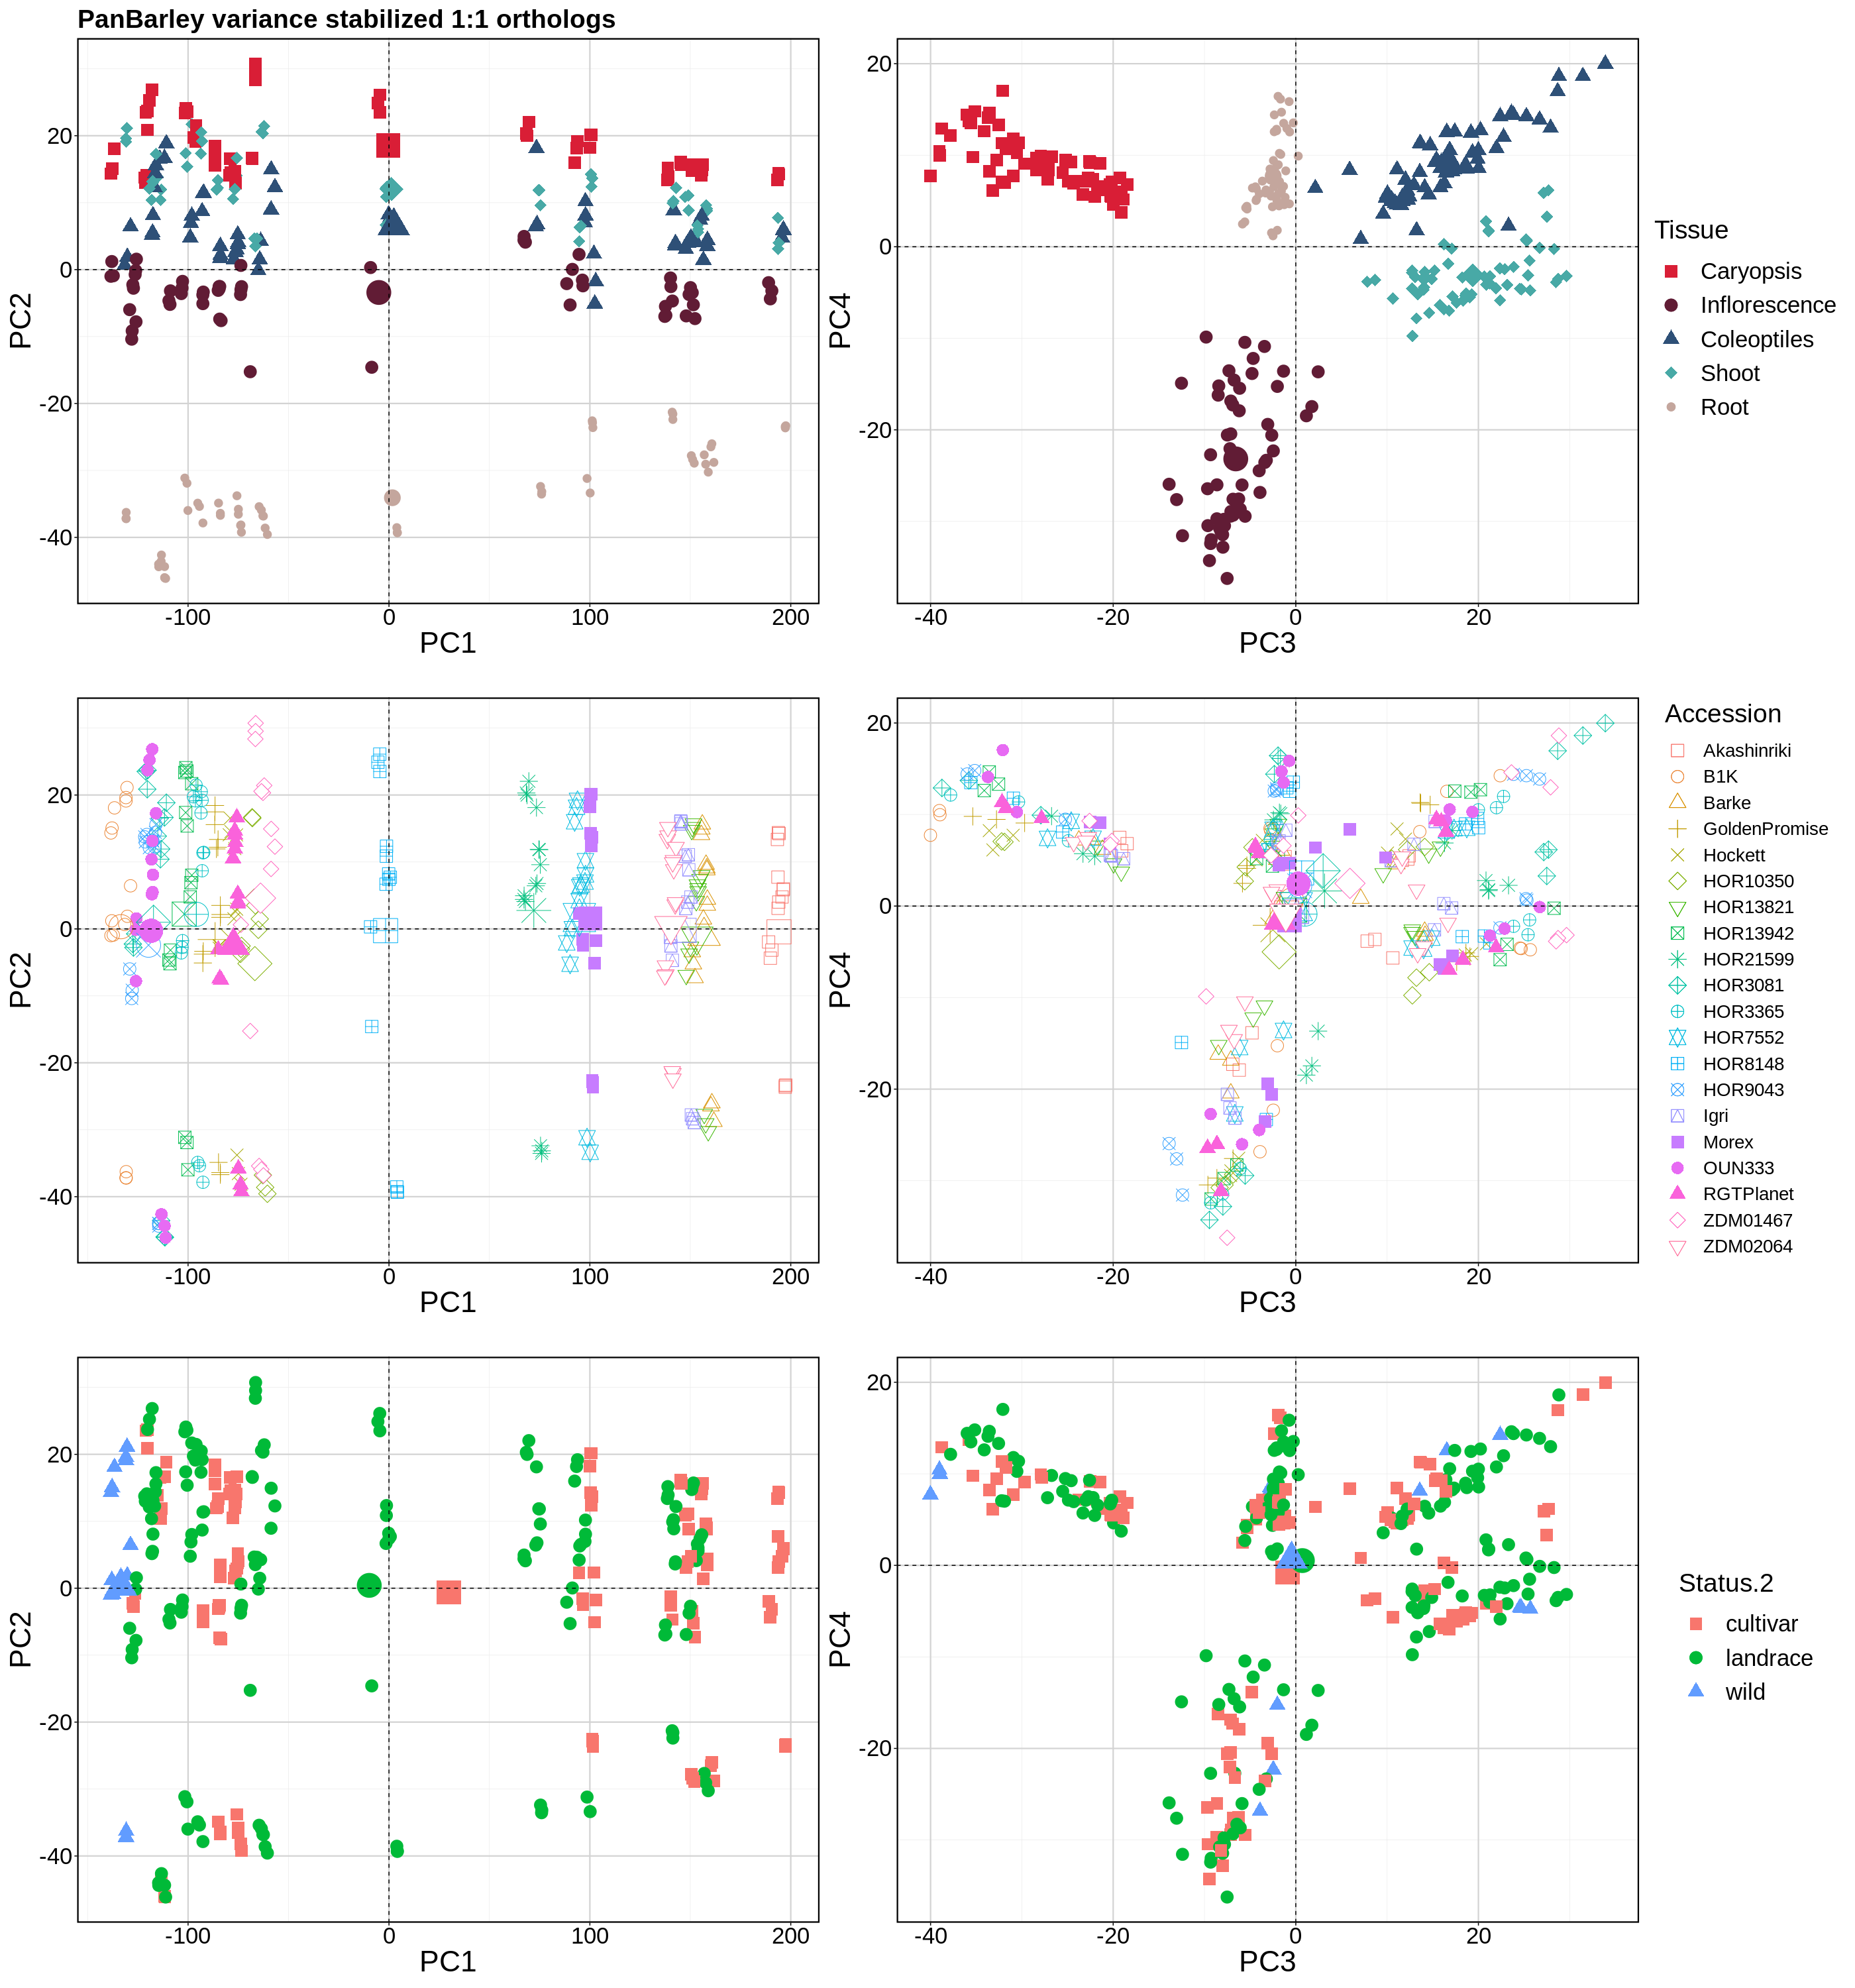

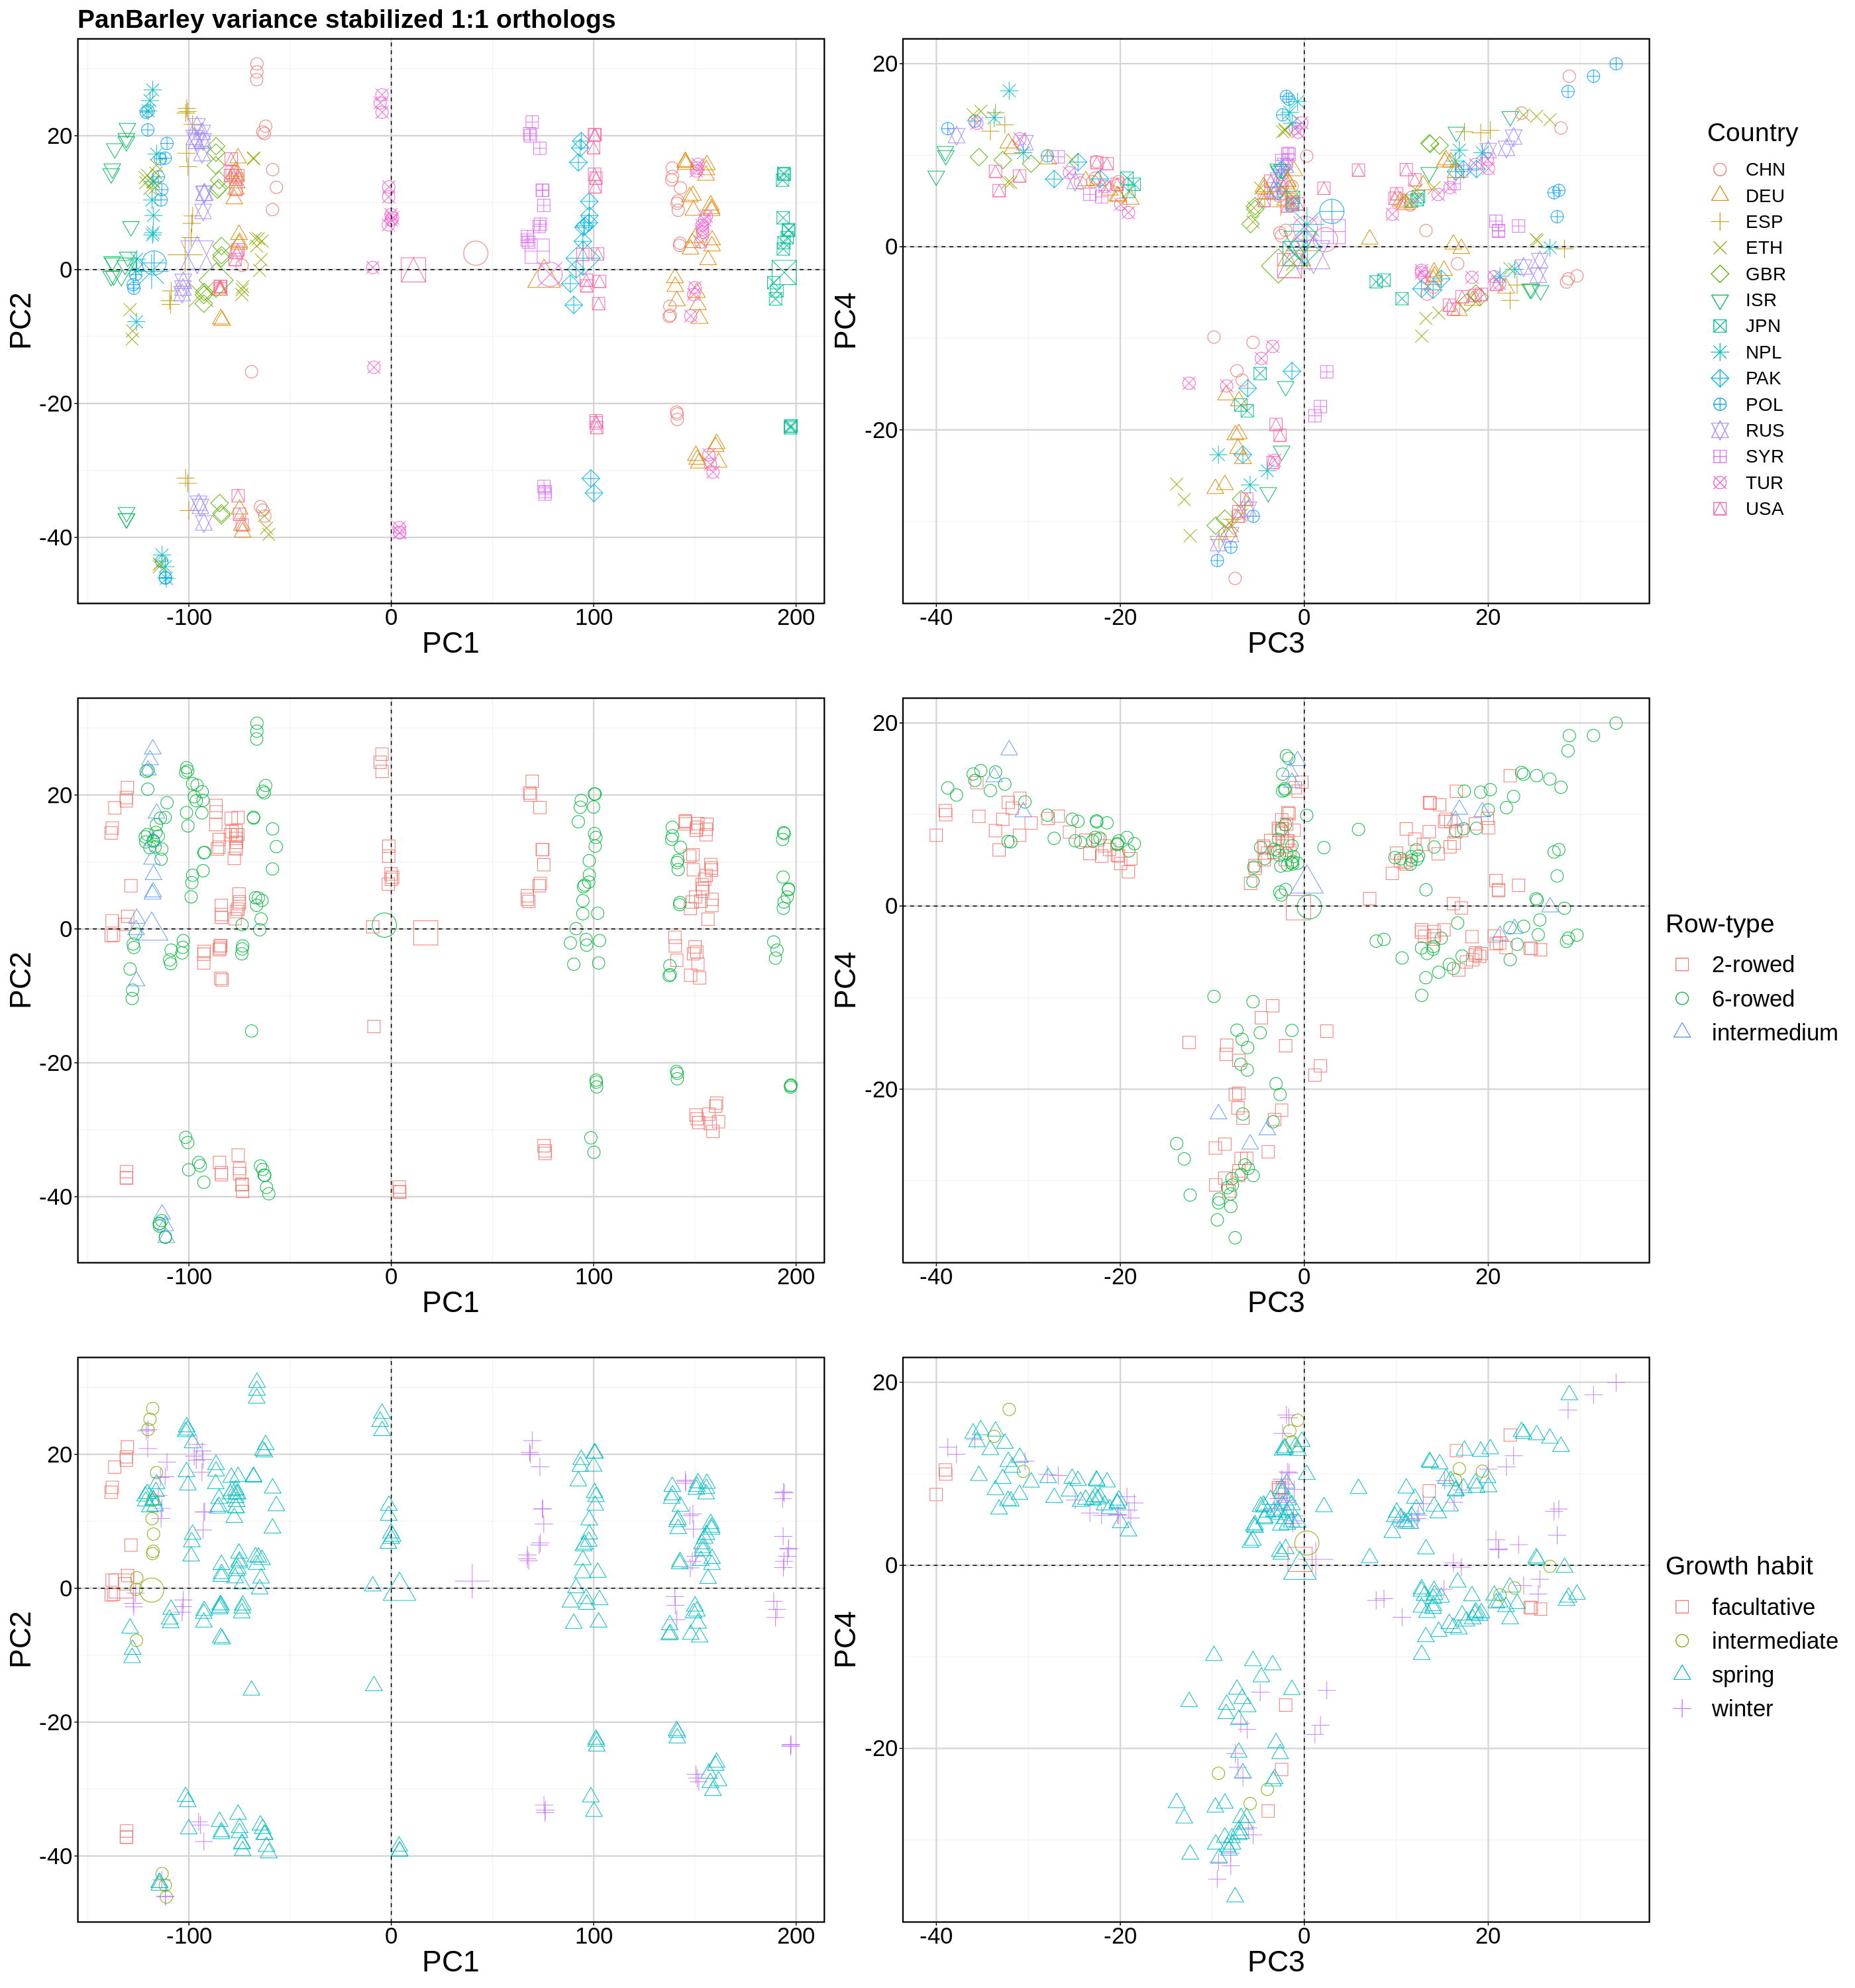

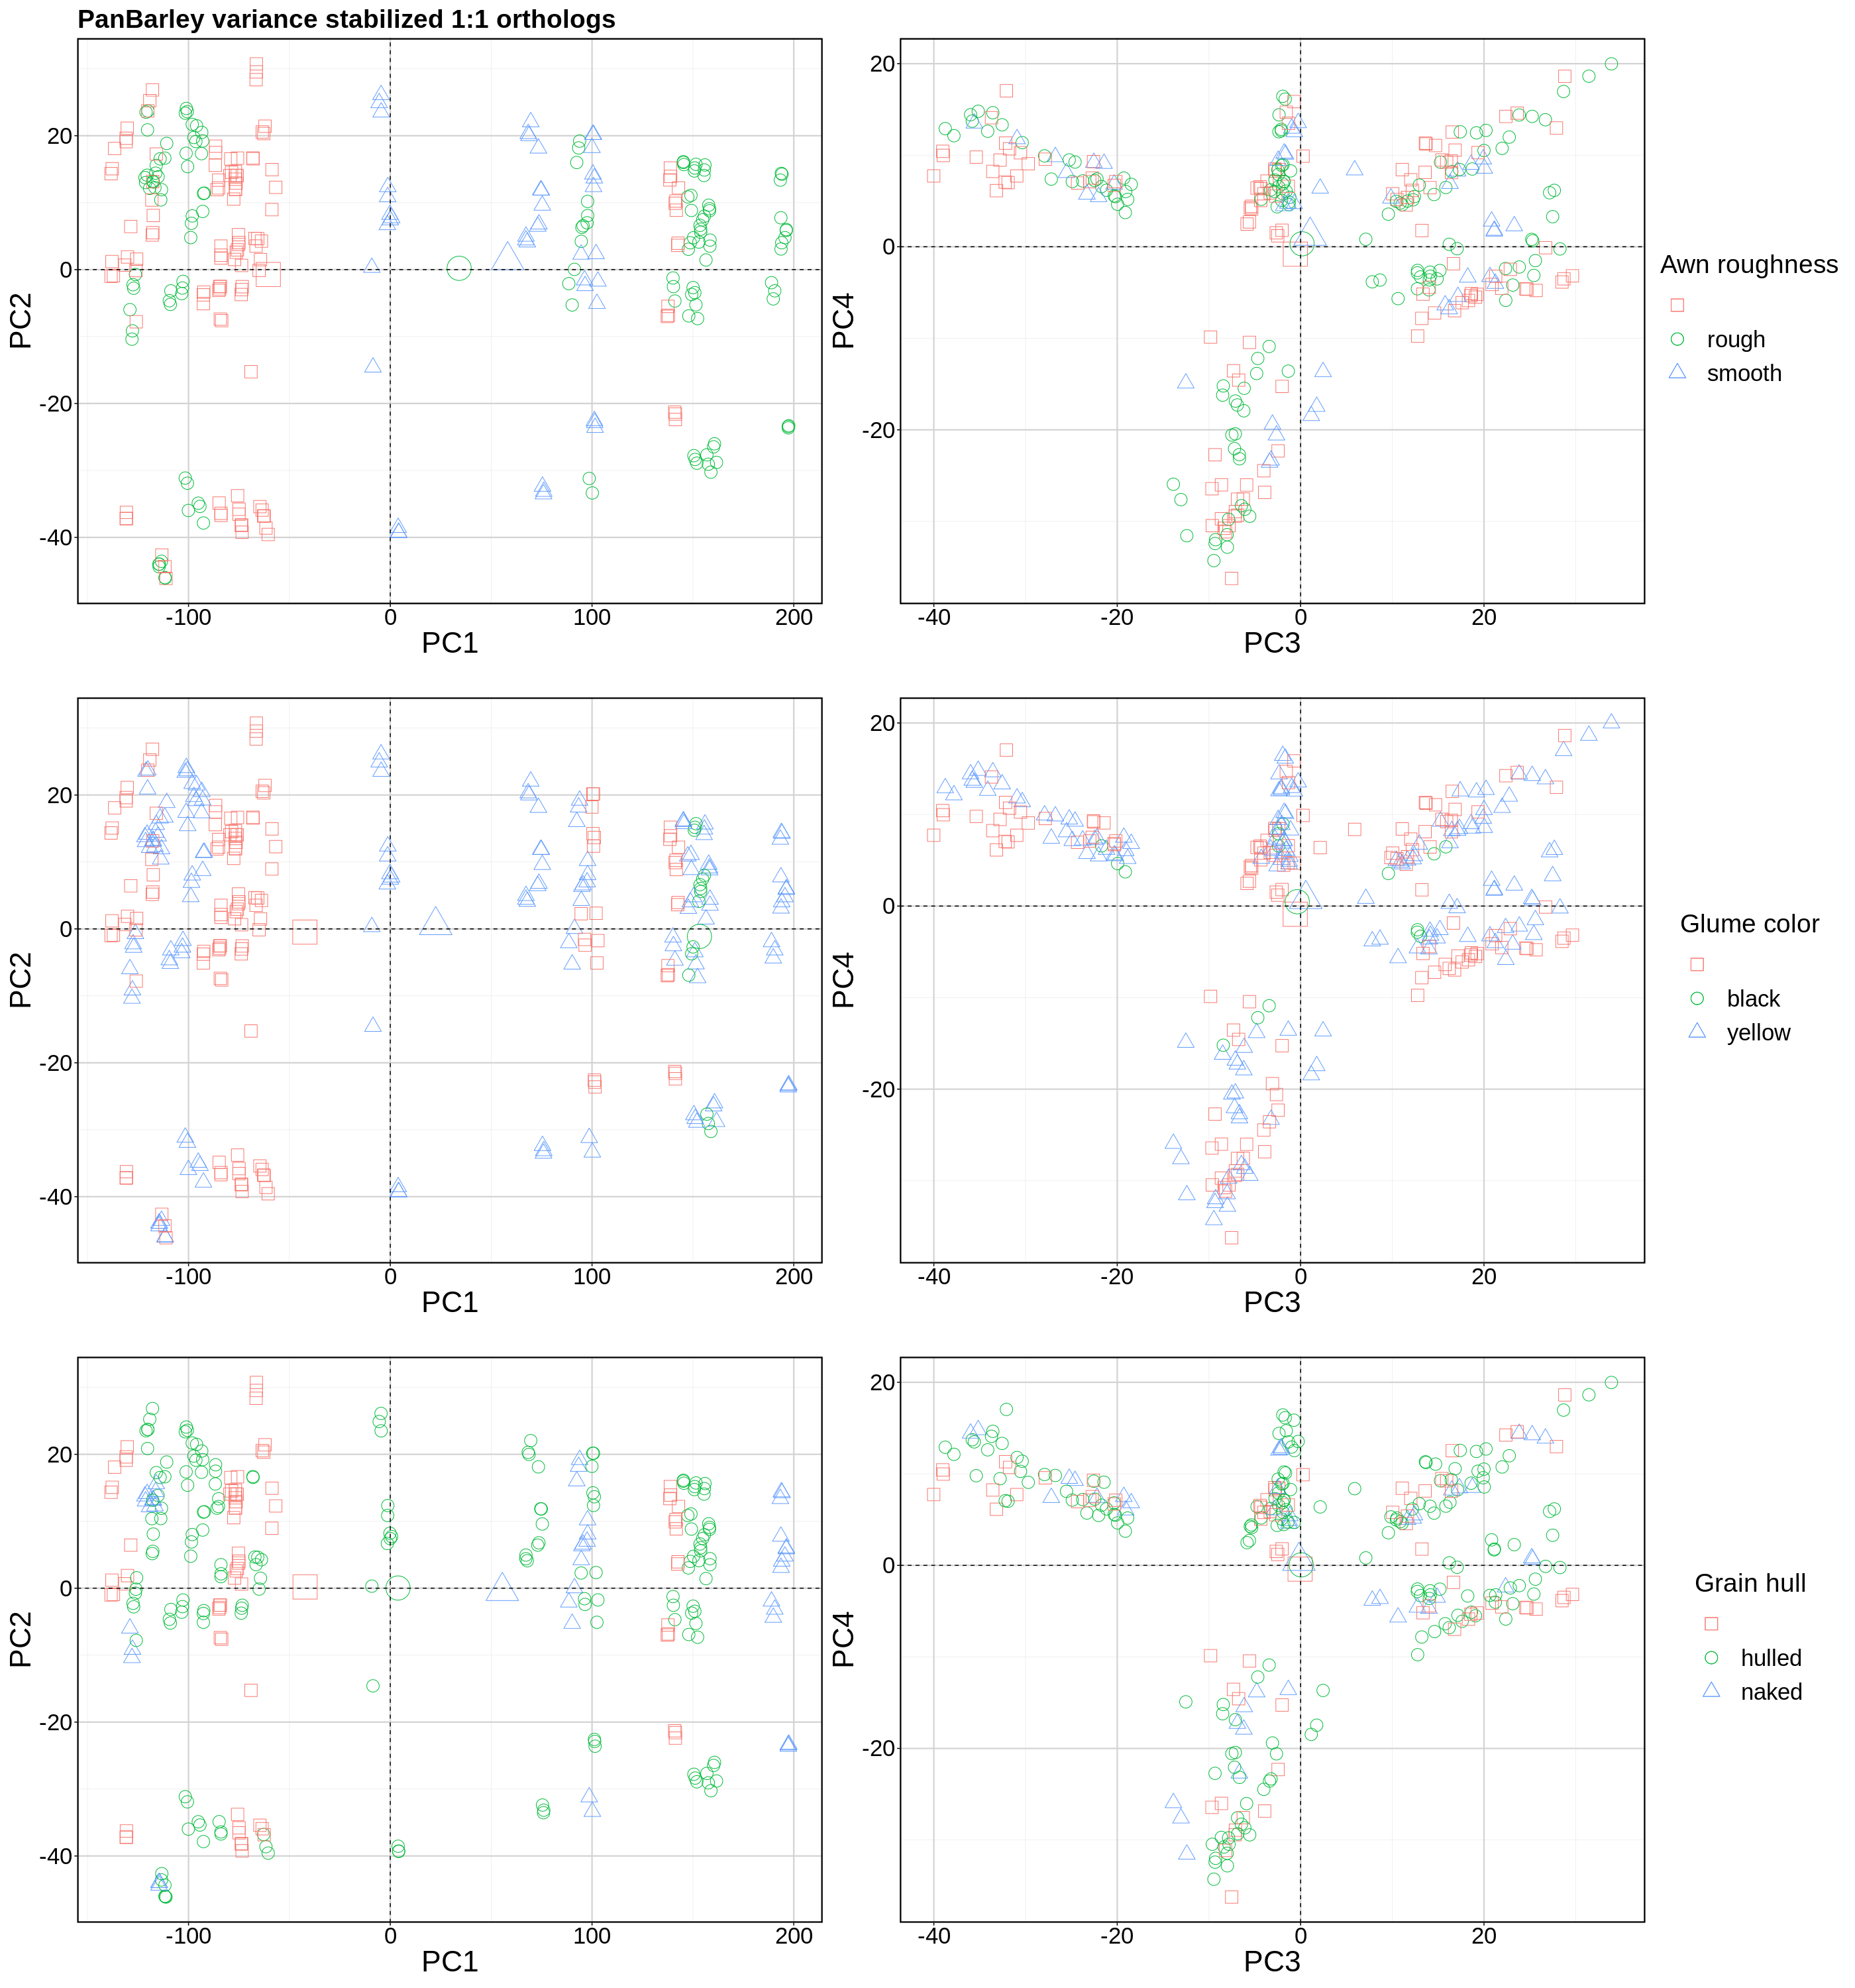

In [6]:
options(repr.plot.width = 28, repr.plot.height = 30, repr.plot.res = 100)
comp <- (pca1 + pca2) / (pca3 + pca4) / (pca5 + pca6)
comp
comp2 <- (pca7 + pca8) / (pca9 + pca10) / (pca11 +pca12)
comp2
comp3 <- (pca13 + pca14) / (pca15 + pca16) / (pca17 +pca18)
comp3

# UMAP

In [7]:
umap = cnt_pca[, grep("chr", colnames(cnt_pca))]
umap_labels = cnt_pca[1:13]
# create umap table
u <- umap(umap)
#head(u)
# inspect table
head(u$layout, 3)
udf <- as.data.frame(u$layout)
#glimpse(udf)
# visualize
u1 <- ggplot(udf, aes(x = V1, y = V2, color = umap_labels$Tissue, shape = umap_labels$Accession)) + 
                labs(title= "PanBarley variance stabilized 1:1 orthologs", x ="UMAP1", y = "UMAP2") +
                geom_point(size = 5) +
                scale_color_manual(name = "Tissue", values = c("#D91E36", "#611C35", "#2E5077", "#48A9A6", "#C4A69D"), 
                                    limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                     labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root")) +
                scale_shape_manual(name = "Accession",
                                   values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,23,25)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6)))
u2 <- ggplot(udf, aes(x = V1, y = V2, color = umap_labels$Accession, shape = umap_labels$Tissue)) + 
                labs(title= "PanBarley variance stabilized 1:1 orthologs", x ="UMAP1", y = "UMAP2") +
                geom_point(size = 5) +
                scale_shape_manual(name = "Tissue", 
                                    limits = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                     labels = c("Caryopsis", "Inflorescence", "Coleoptiles", "Shoot", "Root"),
                                     values = c(0,1,2,3,4)) +
                theme(
                    plot.title = element_text(face = "bold", size = 28),
                    axis.text=element_text(size=25, color = "black"), #change font size of axis text
                    axis.title=element_text(size=32), #change font size of axis titles
                    legend.text=element_text(size=25),
                    legend.title=element_text(size=28),
                    legend.key.size = unit(1.3, 'cm'),
                    legend.background = element_rect(fill="white", size=0.5, colour ="transparent"),
                    legend.key = element_blank(),
                    plot.background = element_rect(fill = "white", colour = "transparent"),
                    panel.background = element_rect(fill = "transparent", colour = "grey"),
                    panel.border = element_rect(fill = NA, colour = "black", size = 1.5),
                    panel.grid.major = element_line(colour = "lightgrey", linetype = "solid", size = 0.75,),
                    strip.background = element_rect(fill = "transparent", colour = "transparent"),
                    axis.ticks=element_line(colour="black"),
                    axis.ticks.length = unit(3, "pt")) + 
                guides(color = guide_legend(override.aes = list(size = 6)))

Akashinriki_Ca1,-1.841850,-7.832672
Akashinriki_Ca2,-2.063773,-7.633122
Akashinriki_Ca3,-1.846893,-7.768256


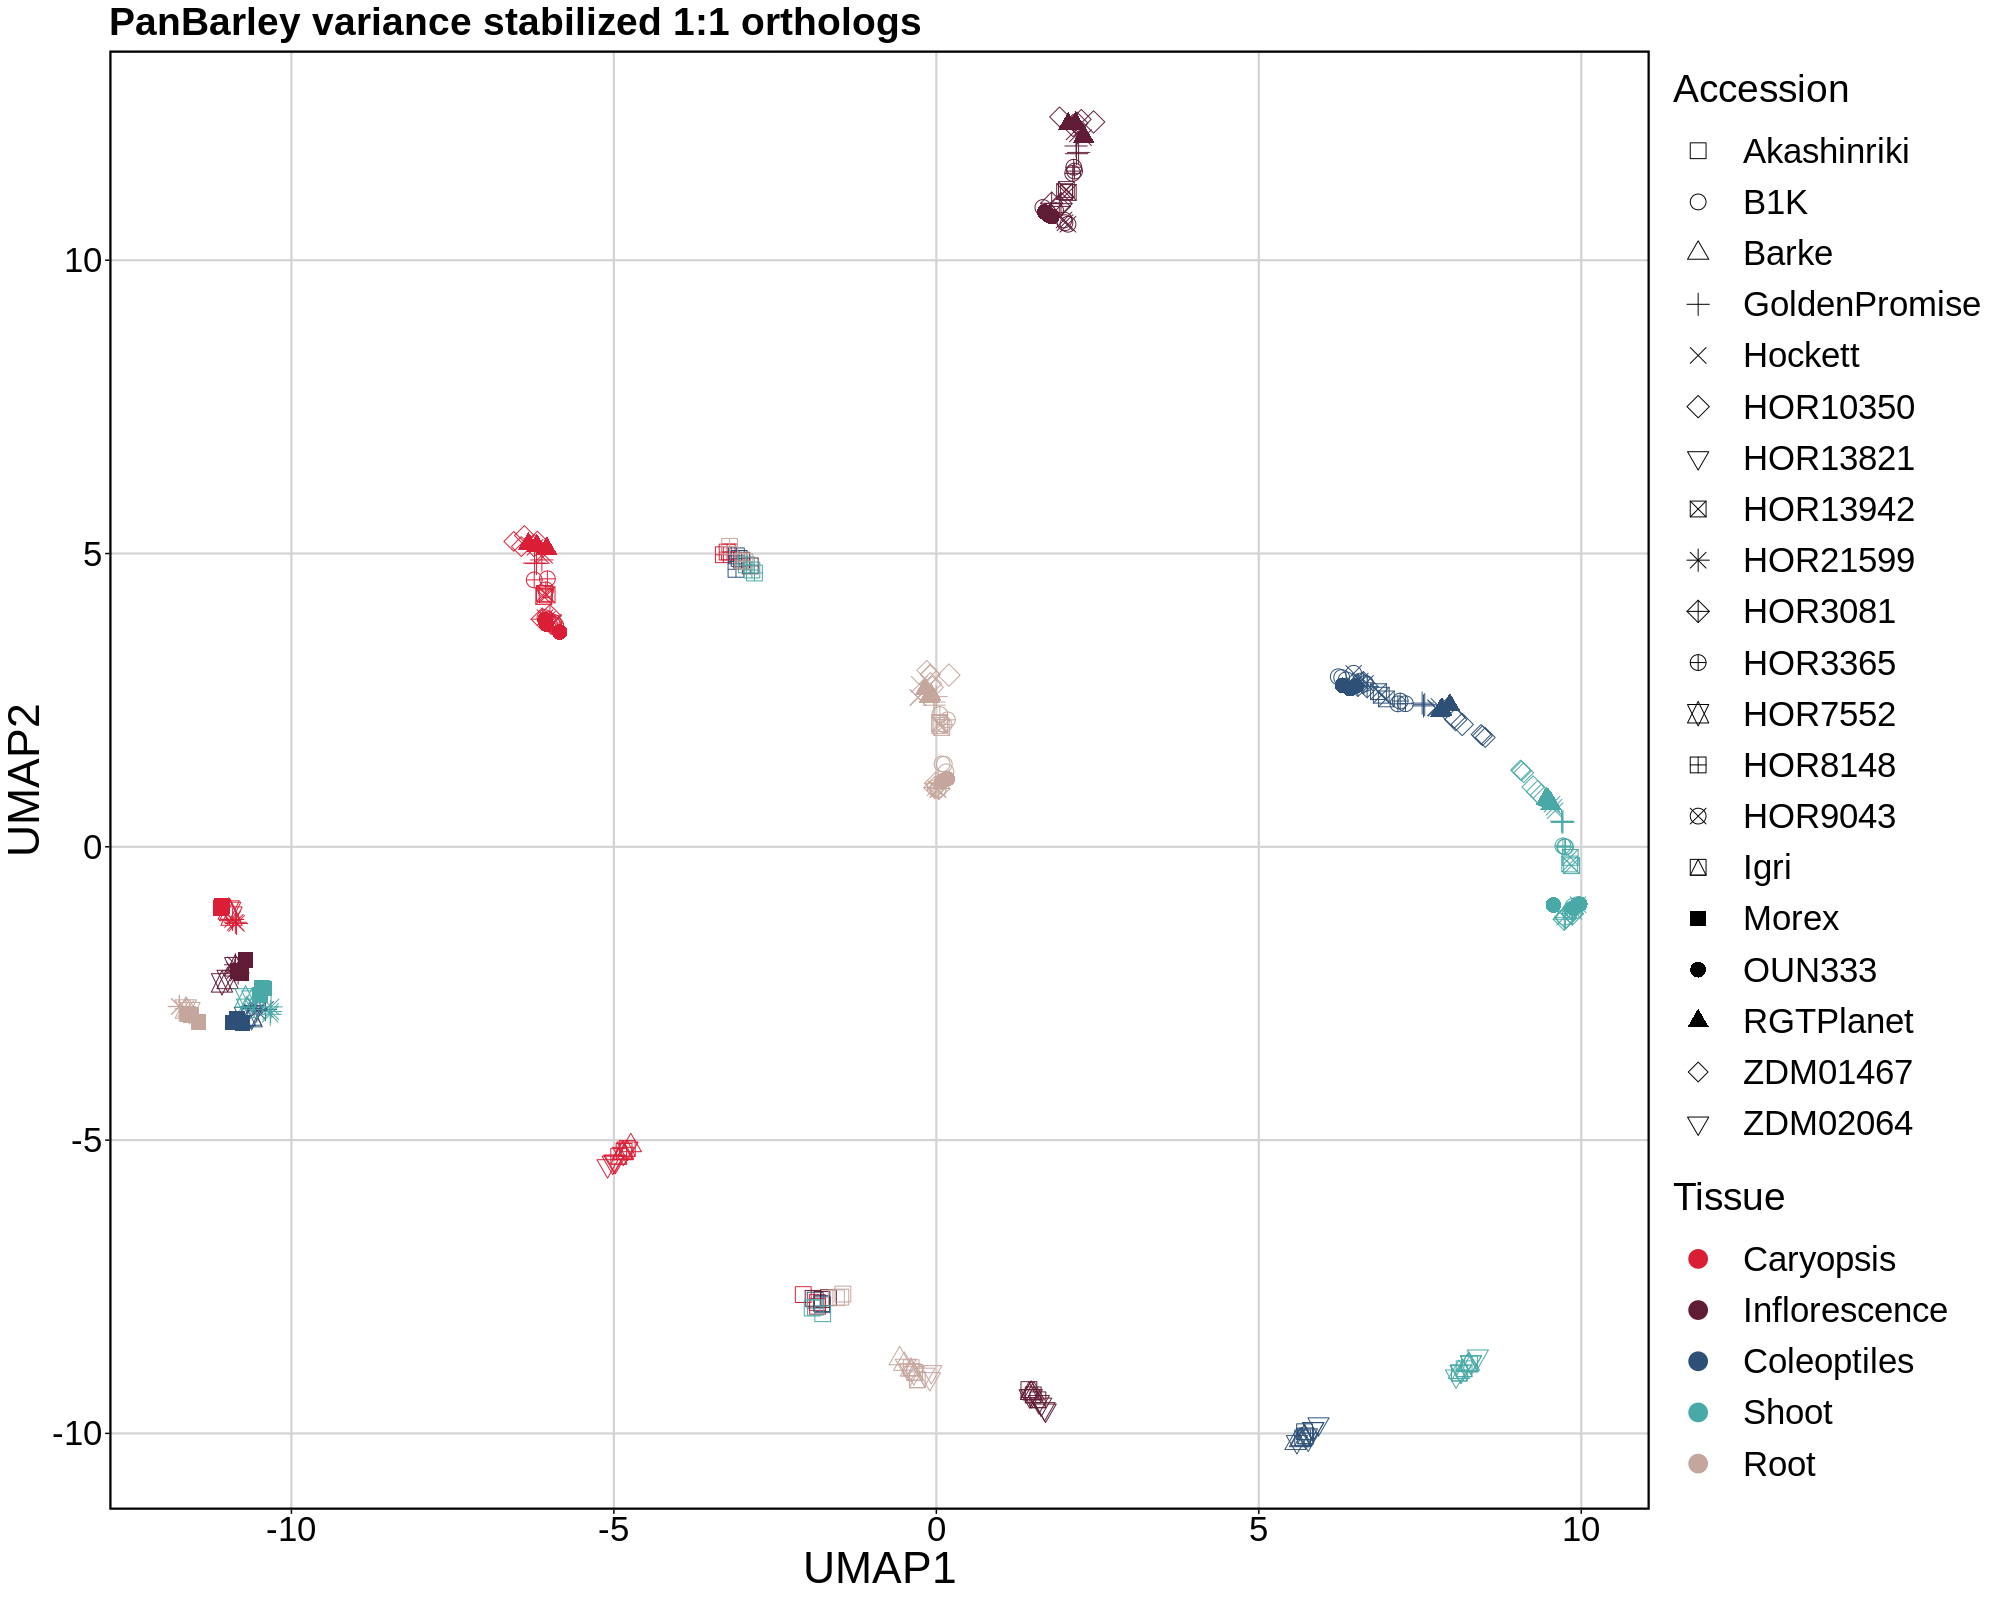

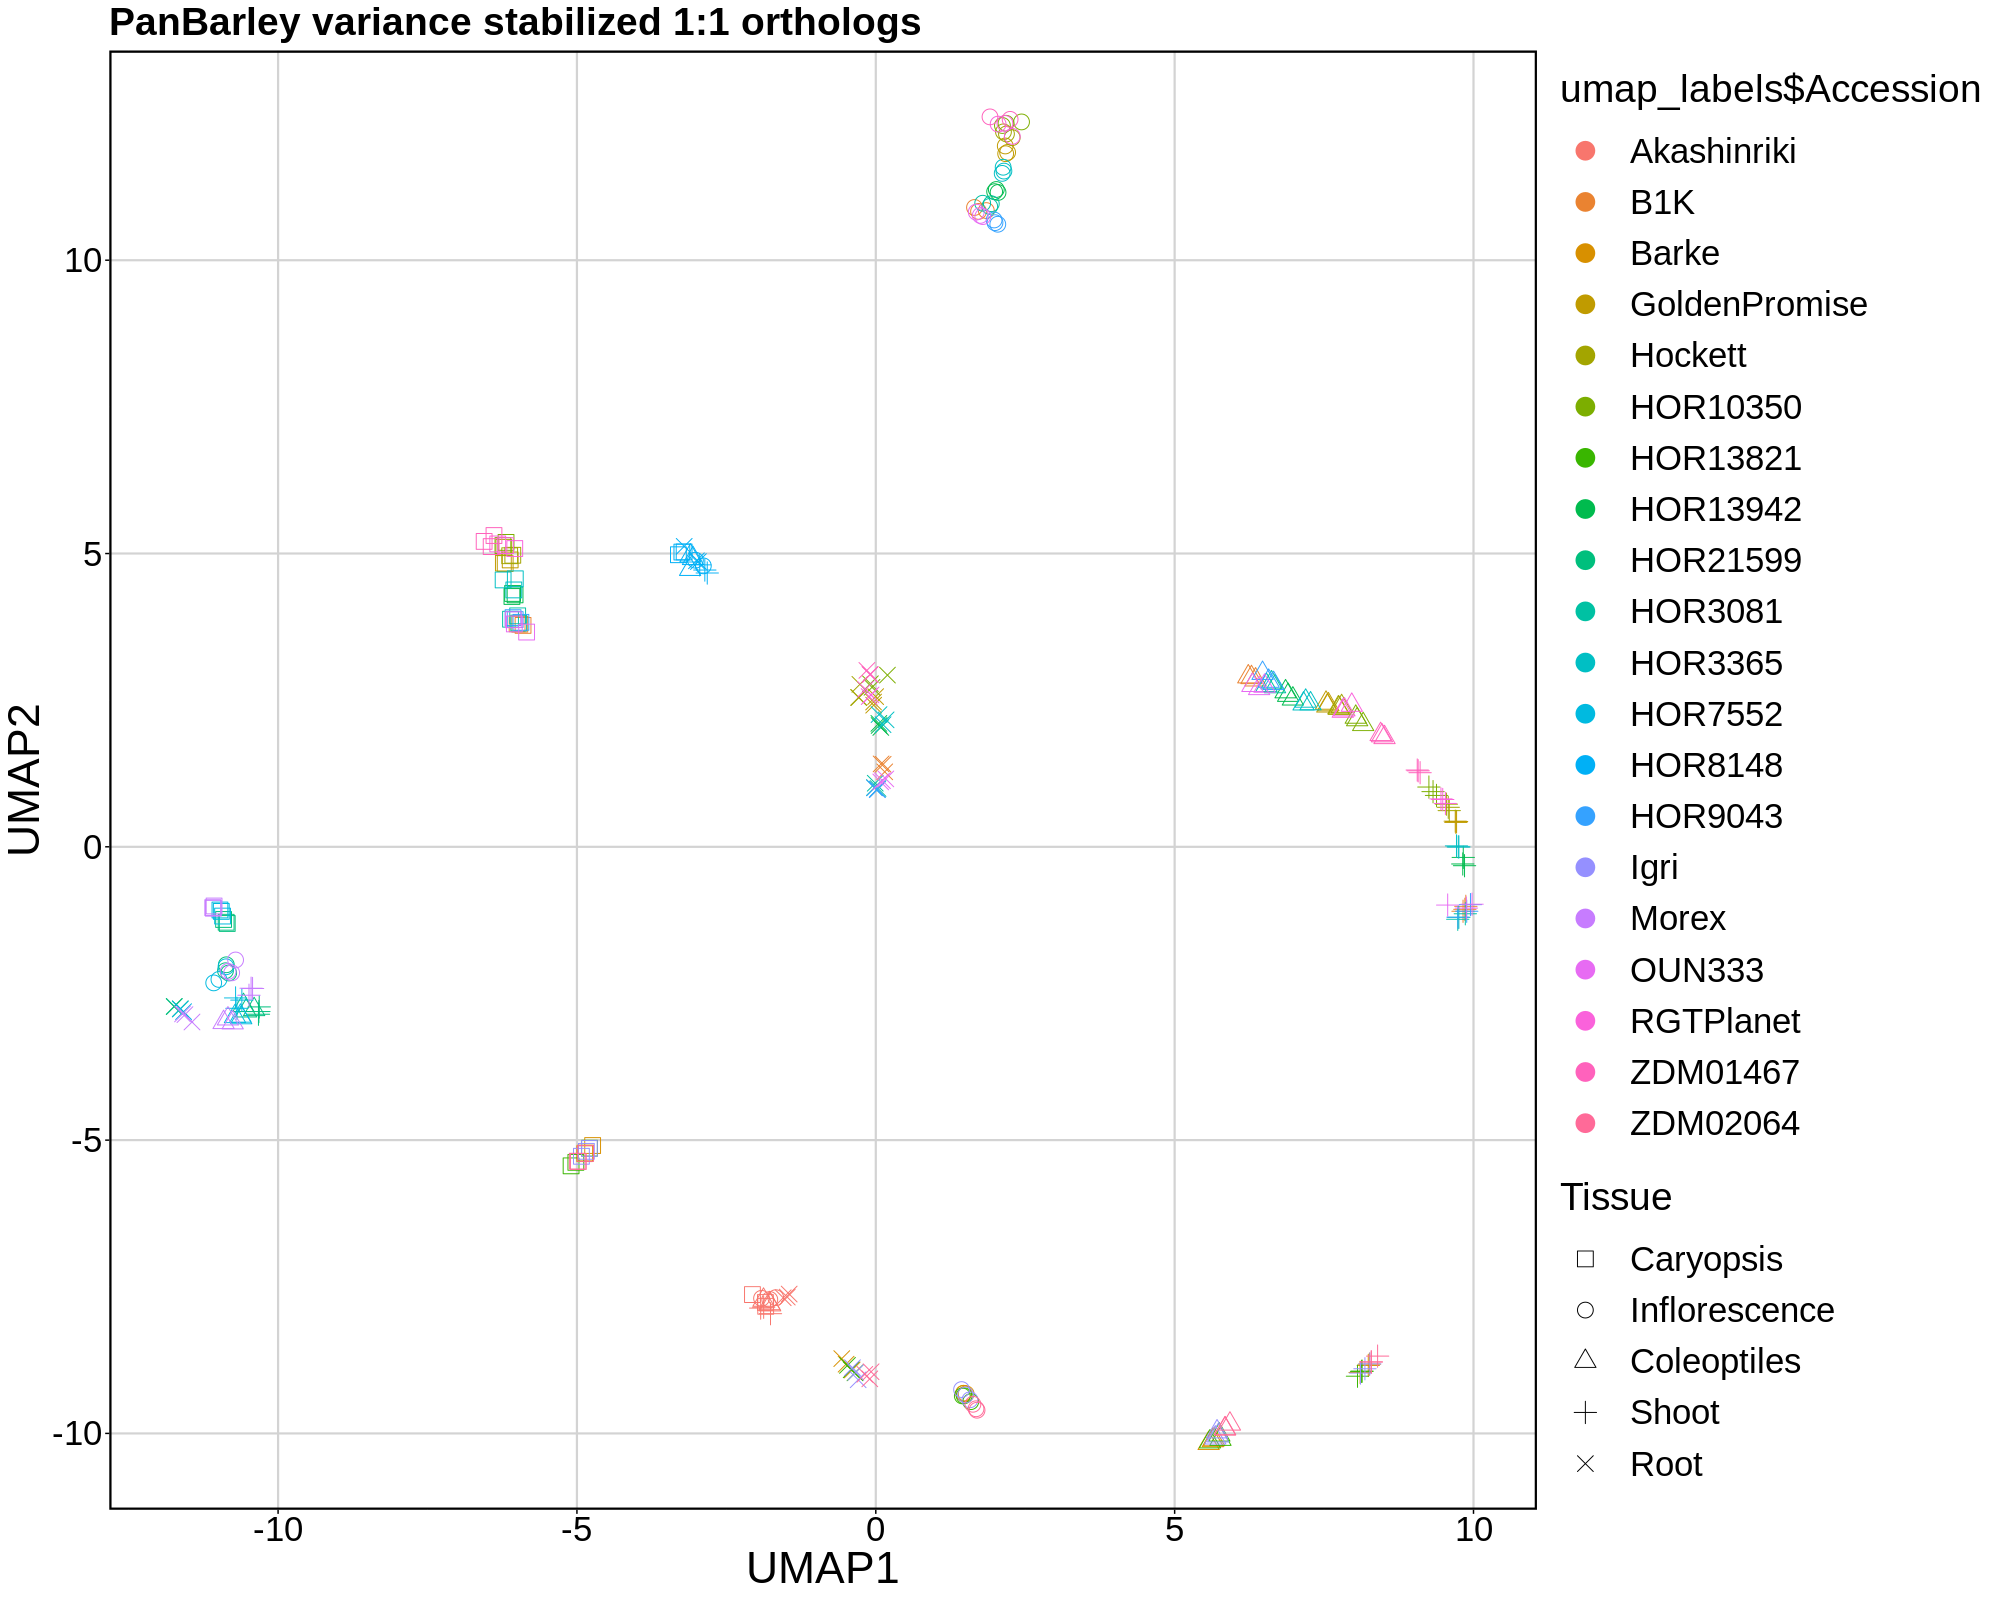

In [8]:
options(repr.plot.width = 20, repr.plot.height = 16, repr.plot.res = 100)
u1
u2

In [9]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/vanda/miniconda3/envs/r/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.2    umap_0.2.10.0      RColorBrewer_1.1-3 factoextra_1.0.7  
 [5] FactoMineR_2.8     cowplot_1.1.1      lubridate_1.9.2    forcats_1.0.0     
 [9] stringr_1.5.0      dplyr_1.1.2        purrr_1.0.1        readr_2.1.4       
[13] tidyr_1.3.0        tibble_3.2.1       ggplot2_3.4.3      tidyv